<a href="https://colab.research.google.com/github/dataplusplus-ai/TimeSeriesAnalysis/blob/main/_multivariate_singlelag_current_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Air Pollution Forecasting
We are going to use the Air Quality dataset and apply LSTM model to predict pollution level for subsequent hours. 

This is a dataset that reports on the weather and the level of pollution each hour for five years at the US embassy in Beijing, China.

The data includes the date-time, the pollution called PM2.5 concentration, and the weather information including dew point, temperature, pressure, wind direction, wind speed and the cumulative number of hours of snow and rain. The complete feature list in the raw data is as follows:

No: row number
year: year of data in this row
month: month of data in this row
day: day of data in this row
hour: hour of data in this row
pm2.5: PM2.5 concentration
DEWP: Dew Point
TEMP: Temperature
PRES: Pressure
cbwd: Combined wind direction
Iws: Cumulated wind speed
Is: Cumulated hours of snow
Ir: Cumulated hours of rain
We can use this data and frame a forecasting problem where, given the weather conditions and pollution for prior hours, we forecast the pollution at the next hour.
The data set is available in this link https://raw.githubusercontent.com/jbrownlee/Datasets/master/pollution.csv
Download the dataset and place it in your current working directory with the filename “raw.csv“.

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime

In [ ]:
raw_data=pd.read_csv('pollution_multivariate.csv')
raw_data.head(3)

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0


In [ ]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43824 entries, 0 to 43823
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   No      43824 non-null  int64  
 1   year    43824 non-null  int64  
 2   month   43824 non-null  int64  
 3   day     43824 non-null  int64  
 4   hour    43824 non-null  int64  
 5   pm2.5   41757 non-null  float64
 6   DEWP    43824 non-null  int64  
 7   TEMP    43824 non-null  float64
 8   PRES    43824 non-null  float64
 9   cbwd    43824 non-null  object 
 10  Iws     43824 non-null  float64
 11  Is      43824 non-null  int64  
 12  Ir      43824 non-null  int64  
dtypes: float64(4), int64(8), object(1)
memory usage: 4.3+ MB


## 2. Basic Data Preparation
The data is not ready to use. We must prepare it first.
The first step is to consolidate the date-time information into a single date-time so that 
we can use it as an index in Pandas.

A quick check reveals NA values for pm2.5 for the first 24 hours. 
We will, therefore, need to remove the first row of data. 
There are also a few scattered “NA” values later in the dataset; we can mark them with 0 values for now.

The script below loads the raw dataset and parses the date-time 
information as the Pandas DataFrame index. The “No” column is dropped and then clearer names are specified for each column.
Finally, the NA values are replaced with “0” values and the first 24 hours are removed.




In [ ]:
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')

In [ ]:
dataset = pd.read_csv('pollution_multivariate.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)

In [ ]:
dataset.head()

,No,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
year_month_day_hour,,,,,,,,,
2010-01-01 00:00:00,1,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,2,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,3,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,4,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,5,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [ ]:
#we do not require the column 'NO' we remove that
dataset.drop('No', axis=1, inplace=True)

In [ ]:
# manually specify column names
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'

In [ ]:
dataset.isnull().sum()

pollution    2067
dew             0
temp            0
press           0
wnd_dir         0
wnd_spd         0
snow            0
rain            0
dtype: int64

In [ ]:
dataset.isnull().sum()

pollution    0
dew          0
temp         0
press        0
wnd_dir      0
wnd_spd      0
snow         0
rain         0
dtype: int64

In [ ]:
# mark all NA values with 0
dataset['pollution'].fillna(0, inplace=True)

In [ ]:
raw_data.head(30)

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0
5,6,2010,1,1,5,NaN,-19,-10.0,1017.0,NW,16.10,0,0
6,7,2010,1,1,6,NaN,-19,-9.0,1017.0,NW,19.23,0,0
7,8,2010,1,1,7,NaN,-19,-9.0,1017.0,NW,21.02,0,0
8,9,2010,1,1,8,NaN,-19,-9.0,1017.0,NW,24.15,0,0
9,10,2010,1,1,9,NaN,-20,-8.0,1017.0,NW,27.28,0,0


In [ ]:
# drop the first 24 hours
dataset = dataset[24:]
# summarize first 5 rows
print(dataset.head(5))
# save to file
#dataset.to_csv('pollution.csv')

                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0


In [ ]:
dataset.shape

(43800, 8)

In [ ]:
print(dataset.index.max(),dataset.index.min())

2014-12-31 23:00:00 2010-01-02 00:00:00


Running this code example creates a plot with 7 subplots showing the 5 years of data for each variable.
except wnd_dir which is a categorical variable.

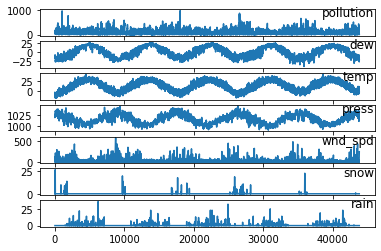

In [ ]:
import matplotlib.pyplot as plt

values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column
plt.figure()
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

# 3. Multivariate LSTM Forecast Model
In this section, we will fit an LSTM to the problem.

## LSTM Data Preparation
The first step is to prepare the pollution dataset for the LSTM.

This involves framing the dataset as a supervised learning problem and normalizing the input variables.

We will frame the supervised learning problem as predicting the pollution at the current hour (t) given the pollution measurement and weather conditions at the prior time step.

This formulation is straightforward and just for this demonstration. Some alternate formulations you could explore include:

Predict the pollution for the next hour based on the weather conditions and pollution over the last 24 hours.
Predict the pollution for the next hour as above and given the “expected” weather conditions for the next hour.
We can transform the dataset using the series_to_supervised() function developed in the blog post:

How to Convert a Time Series to a Supervised Learning Problem in Python
First, the “pollution.csv” dataset is loaded. The wind direction feature is label encoded (integer encoded). This could further be one-hot encoded in the future if you are interested in exploring it.

Next, all features are normalized, then the dataset is transformed into a supervised learning problem. The weather variables for the hour to be predicted (t) are then removed.

The complete code listing is provided below.

In [ ]:
dataset.shape

(43800, 8)

In [ ]:
n_vars = 1 if type(dataset) is list else dataset.shape[1]
n_vars

8

In [ ]:
cols, names = list(), list()
df=dataset.copy()

In [ ]:
df1=df[0:4]
for i in range(n_in, 0, -1):
    print(i)
    cols.append(df1.shift(i)) #i=2 
    names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
print(cols)
print(names)
    

2
1
[                     pollution   dew  temp   press wnd_dir  wnd_spd  snow  \
date                                                                        
2010-01-02 00:00:00        NaN   NaN   NaN     NaN     NaN      NaN   NaN   
2010-01-02 01:00:00        NaN   NaN   NaN     NaN     NaN      NaN   NaN   
2010-01-02 02:00:00      129.0 -16.0  -4.0  1020.0      SE     1.79   0.0   
2010-01-02 03:00:00      148.0 -15.0  -4.0  1020.0      SE     2.68   0.0   

                     rain  
date                       
2010-01-02 00:00:00   NaN  
2010-01-02 01:00:00   NaN  
2010-01-02 02:00:00   0.0  
2010-01-02 03:00:00   0.0  ,                      pollution   dew  temp   press wnd_dir  wnd_spd  snow  \
date                                                                        
2010-01-02 00:00:00        NaN   NaN   NaN     NaN     NaN      NaN   NaN   
2010-01-02 01:00:00      129.0 -16.0  -4.0  1020.0      SE     1.79   0.0   
2010-01-02 02:00:00      148.0 -15.0  -4.0  1020.0     

In [ ]:
for i in range(0, n_out):
    cols.append(df.shift(-i))
if i == 0:
    names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
else:
	names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
print(cols)
print(names)

[                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0
...                        ...  ...   ...     ...     ...      ...   ...   ...
2014-12-31 19:00:00        8.0  -23  -2.0  1034.0      NW   231.97     0     0
2014-12-31 20:00:00       10.0  -22  -3.0  1034.0      NW   237.78     0     0
2014-12-31 21:00:00       10.0  -22  -3.0  1034.0      NW   242.70     0     0
2014-12-31 22:00:00        8.0  -22  -4.0  1034.0      NW   246.72     0     0
2014-12-31 23:00:00       12.0  -21  -3.0  1034.0  

In [ ]:
n_in=2
n_out=2
for i in range(n_in, 0, -1):
		cols.append(df.shift(i)) #i=2 
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
for i in range(0, n_out):
    cols.append(df.shift(-i))
if i == 0:
    names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
else:
	names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
print(cols)
print(names)

[                     pollution   dew  temp   press wnd_dir  wnd_spd  snow  \
date                                                                        
2010-01-02 00:00:00        NaN   NaN   NaN     NaN     NaN      NaN   NaN   
2010-01-02 01:00:00        NaN   NaN   NaN     NaN     NaN      NaN   NaN   
2010-01-02 02:00:00      129.0 -16.0  -4.0  1020.0      SE     1.79   0.0   
2010-01-02 03:00:00      148.0 -15.0  -4.0  1020.0      SE     2.68   0.0   
2010-01-02 04:00:00      159.0 -11.0  -5.0  1021.0      SE     3.57   0.0   
...                        ...   ...   ...     ...     ...      ...   ...   
2014-12-31 19:00:00        9.0 -22.0  -1.0  1033.0      NW   221.24   0.0   
2014-12-31 20:00:00       10.0 -22.0  -2.0  1033.0      NW   226.16   0.0   
2014-12-31 21:00:00        8.0 -23.0  -2.0  1034.0      NW   231.97   0.0   
2014-12-31 22:00:00       10.0 -22.0  -3.0  1034.0      NW   237.78   0.0   
2014-12-31 23:00:00       10.0 -22.0  -3.0  1034.0      NW   242.70   0.0  

In [ ]:
# prepare data for lstm
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# load dataset
#dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
#reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.129779   0.352941   0.245902   0.527273   0.666667   0.002290   
2   0.148893   0.367647   0.245902   0.527273   0.666667   0.003811   
3   0.159960   0.426471   0.229508   0.545454   0.666667   0.005332   
4   0.182093   0.485294   0.229508   0.563637   0.666667   0.008391   
5   0.138833   0.485294   0.229508   0.563637   0.666667   0.009912   

   var7(t-1)  var8(t-1)   var1(t)   var2(t)   var3(t)   var4(t)   var5(t)  \
1   0.000000        0.0  0.148893  0.367647  0.245902  0.527273  0.666667   
2   0.000000        0.0  0.159960  0.426471  0.229508  0.545454  0.666667   
3   0.000000        0.0  0.182093  0.485294  0.229508  0.563637  0.666667   
4   0.037037        0.0  0.138833  0.485294  0.229508  0.563637  0.666667   
5   0.074074        0.0  0.109658  0.485294  0.213115  0.563637  0.666667   

    var6(t)   var7(t)  var8(t)  
1  0.003811  0.000000      0.0  
2  0.005332  0.000000      0.0  
3  0.008391

In [ ]:
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)

This data preparation is simple and there is more we could explore. Some ideas you could look at include:

One-hot encoding wind direction.
Making all series stationary with differencing and seasonal adjustment.
Providing more than 1 hour of input time steps.
This last point is perhaps the most important given the use of Backpropagation through time by LSTMs when learning sequence prediction problems.

## Define and Fit Model
In this section, we will fit an LSTM on the multivariate input data.

First, we must split the prepared dataset into train and test sets. To speed up the training of the model for this demonstration, we will only fit the model on the first year of data, then evaluate it on the remaining 4 years of data. If you have time, consider exploring the inverted version of this test harness.

The example below splits the dataset into train and test sets, then splits the train and test sets into input and output variables. Finally, the inputs (X) are reshaped into the 3D format expected by LSTMs, namely [samples, timesteps, features].

In [ ]:
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]


In [ ]:
train_y[0:5]

array([0.14889336, 0.15995975, 0.18209255, 0.13883299, 0.10965794],
      dtype=float32)

In [ ]:
train_X[0:5]

array([[0.12977867, 0.35294122, 0.24590163, 0.5272732 , 0.6666667 ,
        0.00229001, 0.        , 0.        ],
       [0.14889336, 0.36764708, 0.24590163, 0.5272732 , 0.6666667 ,
        0.00381099, 0.        , 0.        ],
       [0.15995975, 0.4264706 , 0.22950819, 0.545454  , 0.6666667 ,
        0.00533197, 0.        , 0.        ],
       [0.18209255, 0.48529413, 0.22950819, 0.5636368 , 0.6666667 ,
        0.00839101, 0.03703704, 0.        ],
       [0.13883299, 0.48529413, 0.22950819, 0.5636368 , 0.6666667 ,
        0.00991199, 0.07407407, 0.        ]], dtype=float32)

In [ ]:
print(train_X.shape,test_X.shape)

(8760, 8) (35039, 8)


In [ ]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 1, 8) (8760,) (35039, 1, 8) (35039,)


Now we can define and fit our LSTM model.

We will define the LSTM with 50 neurons in the first hidden layer and 1 neuron in the output layer for predicting pollution. The input shape will be 1 time step with 8 features.

We will use the Mean Absolute Error (MAE) loss function and the efficient Adam version of stochastic gradient descent.

The model will be fit for 50 training epochs with a batch size of 72. Remember that the internal state of the LSTM in Keras is reset at the end of each batch, so an internal state that is a function of a number of days may be helpful (try testing this).

Finally, we keep track of both the training and test loss during training by setting the validation_data argument in the fit() function. At the end of the run both the training and test loss are plotted.

In [ ]:
...
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history


Epoch 1/50
122/122 - 6s - loss: 0.0549 - val_loss: 0.0554
Epoch 2/50
122/122 - 3s - loss: 0.0382 - val_loss: 0.0550
Epoch 3/50
122/122 - 3s - loss: 0.0216 - val_loss: 0.0464
Epoch 4/50
122/122 - 4s - loss: 0.0168 - val_loss: 0.0341
Epoch 5/50
122/122 - 6s - loss: 0.0156 - val_loss: 0.0229
Epoch 6/50
122/122 - 4s - loss: 0.0151 - val_loss: 0.0186
Epoch 7/50
122/122 - 4s - loss: 0.0150 - val_loss: 0.0176
Epoch 8/50
122/122 - 4s - loss: 0.0150 - val_loss: 0.0166
Epoch 9/50
122/122 - 6s - loss: 0.0149 - val_loss: 0.0158
Epoch 10/50
122/122 - 6s - loss: 0.0149 - val_loss: 0.0152
Epoch 11/50
122/122 - 7s - loss: 0.0147 - val_loss: 0.0144
Epoch 12/50
122/122 - 6s - loss: 0.0147 - val_loss: 0.0144
Epoch 13/50
122/122 - 5s - loss: 0.0147 - val_loss: 0.0143
Epoch 14/50
122/122 - 5s - loss: 0.0147 - val_loss: 0.0145
Epoch 15/50
122/122 - 4s - loss: 0.0148 - val_loss: 0.0141
Epoch 16/50
122/122 - 5s - loss: 0.0146 - val_loss: 0.0142
Epoch 17/50
122/122 - 5s - loss: 0.0146 - val_loss: 0.0138
Epoch 

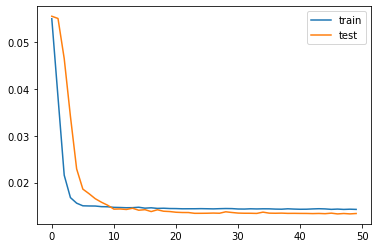

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## Evaluate Model
After the model is fit, we can forecast for the entire test dataset.

We combine the forecast with the test dataset and invert the scaling. We also invert scaling on the test dataset with the expected pollution numbers.

With forecasts and actual values in their original scale, we can then calculate an error score for the model. In this case, we calculate the Root Mean Squared Error (RMSE) that gives error in the same units as the variable itself.

In [ ]:
test_X[0]

array([[0.0362173 , 0.33823532, 0.1967213 , 0.83636475, 0.33333334,
        0.12757413, 0.        , 0.        ]], dtype=float32)

In [ ]:
test_X.shape

(35039, 1, 8)

In [ ]:
test_x=test_X.copy()

In [ ]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
print(test_X.shape)
print(test_X[0])

(35039, 8)
[0.0362173  0.33823532 0.1967213  0.83636475 0.33333334 0.12757413
 0.         0.        ]


In [ ]:
yhat[0:5]

array([[0.0347351 ],
       [0.0313425 ],
       [0.02056081],
       [0.01933851],
       [0.01893271]], dtype=float32)

In [ ]:
test_X[0]

array([0.0362173 , 0.33823532, 0.1967213 , 0.83636475, 0.33333334,
       0.12757413, 0.        , 0.        ], dtype=float32)

In [ ]:
from numpy import concatenate
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
print(inv_yhat[0])
inv_yhat = scaler.inverse_transform(inv_yhat)
print(inv_yhat[0])

[0.0347351  0.33823532 0.1967213  0.83636475 0.33333334 0.12757413
 0.         0.        ]
[ 3.4526688e+01 -1.7000000e+01 -7.0000000e+00  1.0370000e+03
  1.0000000e+00  7.5099998e+01  0.0000000e+00  0.0000000e+00]


In [ ]:
inv_yhat[0:4]

array([[ 3.4526688e+01, -1.7000000e+01, -7.0000000e+00,  1.0370000e+03,
         1.0000000e+00,  7.5099998e+01,  0.0000000e+00,  0.0000000e+00],
       [ 3.1154449e+01, -1.7000000e+01, -7.0000000e+00,  1.0370000e+03,
         0.0000000e+00,  4.0200000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 2.0437445e+01, -1.7000000e+01, -7.0000000e+00,  1.0370000e+03,
         0.0000000e+00,  8.9399996e+00,  0.0000000e+00,  0.0000000e+00],
       [ 1.9222479e+01, -1.8000000e+01, -8.0000000e+00,  1.0370000e+03,
         1.0000000e+00,  4.0200000e+00,  0.0000000e+00,  0.0000000e+00]],
      dtype=float32)

In [ ]:
inv_yhat = inv_yhat[:,0]
print(inv_yhat[0])

34.526688


In [ ]:
print(test_y[0])

0.03118712


In [ ]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
print(test_y[0])

[0.03118712]


In [ ]:
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
print(inv_y[0])
inv_y = scaler.inverse_transform(inv_y)
print(inv_y[0])

[0.03118712 0.33823532 0.1967213  0.83636475 0.33333334 0.12757413
 0.         0.        ]
[ 3.100e+01 -1.700e+01 -7.000e+00  1.037e+03  1.000e+00  7.510e+01
  0.000e+00  0.000e+00]


In [ ]:
inv_y = inv_y[:,0]
print(inv_y[0])
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

31.0
Test RMSE: 26.551
